In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib

In [3]:
from __future__ import print_function, division
import six
import pathcustomize, about
about.about()
import waldo
import waldo.wio as wio

Python 3.4.3 (default, Mar  6 2015 12:07:41) [GCC 4.2.1 (Apple Inc. build 5577)] on darwin, Host: peters-MacBook-Air.local


In [4]:
names = 'ABCDEFGHI'
dfs = [pd.read_excel('/Users/peterwinter/Desktop/validation/PeterWinter-Validation.xlsx', sheetname=i) for i in names]

In [5]:
name_to_eid = {'A': '20160712_161305-1',
 'B': '20160712_131743-3',
 'C': '20160712_140807-1',
 'D': '20160712_142201-2',
 'E': '20160712_105713-1',
 'F': '20160712_125324-2',
 'G': '20160712_163736-3',
 'H': '20160712_162505-2',
 'I': '20160712_130504-1'}

eid_to_name = {}
for a, b in name_to_eid.items():
    eid_to_name[b] = a

In [6]:
def prep_df(df, name='A'):
    df.columns = [i.strip() for i in df.columns]
    data = df.set_index('Blob_ids')
    good_ids = []
    eid = None
    for i in data.index:
        if type(i) is int:
            if not np.isnan(i):
                good_ids.append(i)
        if type(i) is str and eid is None:
            eid = data.loc[i, 'Start Time']
                
    data = data.loc[good_ids]
    data['name'] = name
    data['bid'] = data['name'] + np.array(data.index, dtype='str')
    data.reset_index(inplace=True)
    data = data.set_index('bid')
    data['minutes'] = (data['End Time'] - data['Start Time']) / (1000. * 60.)
    data['good'] = (data['Was Correct Throughout'] == 'yes')
    return data, eid


def assign_errors(df):
    multiworm_bids = []
    part_bad_bids = []
    id_switch_bids = []

    for bid, row in df.iterrows():
        
        if row['good']:
            continue
        if type(row['if, no, why?']) is not str:
            continue
        #print(bid, row['if, no, why?'])
        if row['if, no, why?'] in ['muliworm','multiworm']:
            multiworm_bids.append(bid)
        elif row['if, no, why?'] in ['part-multiword', 'part-multiworm', 'single+collisoin']:
            part_bad_bids.append(bid)
        elif 'id-' in row['if, no, why?']:
            id_switch_bids.append(bid)
            #print(bid, row['if, no, why?'])
        elif row['if, no, why?'] == 'part-multiworm, id-switch':
            id_switch_bids.append(bid)
            part_bad_bids.append(bid)
        else:
            print('? ==', row['if, no, why?'])

    df['collision'] = False
    df['part-bad'] = False
    df['id-switch'] = False

    df.loc[multiworm_bids, 'collision'] = True
    df.loc[part_bad_bids, 'part-bad'] = True
    df.loc[id_switch_bids, 'id-switch'] = True
    

def combine_dfs_from_sheet(names, dfs, eid_to_name, name_to_eid):
    all_data = []
    for name, df in zip(names, dfs):
        data, eid = prep_df(df, name=name)
        assign_errors(data)
        eid = name_to_eid[name]
        print(name, eid)
        all_data.append(data)
        name_to_eid[name] = eid
        eid_to_name[eid] = name

    df = pd.concat(all_data, axis=0)
    #df = df[df['Was Single Worm?'].isnull() == False]
    return df

df = combine_dfs_from_sheet(names, dfs, eid_to_name, name_to_eid)
df = df[df['name'] == 'A']
df.head().T

A 20160712_161305-1
B 20160712_131743-3
C 20160712_140807-1
D 20160712_142201-2
E 20160712_105713-1
F 20160712_125324-2
G 20160712_163736-3
H 20160712_162505-2
I 20160712_130504-1


bid,A1,A2,A3,A4,A5
Blob_ids,1,2,3,4,5
Start Time,10,10,10,10,10
End Time,600070,305632,194933,600070,128800
Worms next ID,NaN,216,140,NaN,105
Was Correct Throughout,yes,no,yes,yes,no
"if, no, why?",NaN,part-multiworm,NaN,NaN,part-multiworm
Reason Lost,NaN,collision,edge,NaN,NaN
# Correct Collisions,1,2,1,NaN,NaN
# Wrong Collisions,NaN,NaN,NaN,NaN,NaN
# Wrong Gaps,NaN,NaN,NaN,NaN,NaN


In [7]:
#good_tracks
multiworm_tracks = list(df[df['collision']]['Blob_ids'])
multiworm_tracks

[241]

In [ ]:
#df[['Blob_ids', 'collision']]

In [9]:
eids = list(eid_to_name)
eid = name_to_eid['A']
eid

'20160712_161305-1'

In [10]:
def read_waldo_blob_file(bfile_path):
    bid = None
    xy_df = None
    xs =[]
    ys = []
    frames = []
    times = []
    with open(str(bfile_path), 'r') as f:
        for line in f:
            if line[0] == '%' or line[0] == ' %':
                bid = int(line.strip().strip('%'))
            else:
                data = [i for i in line.split()[:4]]
                frames.append(int(data[0]))
                times.append(float(data[1]))
                #print(data)
                
                xs.append(float(data[2]))
                ys.append(float(data[3]))

    xy_df = pd.DataFrame([xs, ys, times], columns=frames, index=['x', 'y', 'time']).T
    # downsample df
    xy_df[xy_df.index % 5 == 0]
    xy_df.name = bid
    if len(set(xy_df.index)) != len(xy_df):
        print('WARNING', bid, 'has duplicate frames')
    return bid, xy_df
    
def compile_xdf_ydf(blob_dir):
    xs, ys, ts = [], [], []
    for bfile_path in blob_dir.glob('*.blobs'):
        bid, xy = read_waldo_blob_file(bfile_path)
        #for bid, xy in zip(bids, xys):
        x = xy.x
        y = xy.y
        t = xy.time
        x.name = bid
        y.name = bid
        xs.append(x)
        ys.append(y)
        ts.append(t)

    xdf = pd.concat(xs, axis=1)
    ydf = pd.concat(ys, axis=1)
    tdf = pd.concat(ts, axis=1).median(axis=1)
    xdf.columns.name= 'bid'
    xdf.index.name = 'frame'
    ydf.columns.name= 'bid'
    ydf.index.name = 'frame'
    return xdf, ydf, tdf


# bid, xy = read_waldo_blob_file(bfile_path)
# print(bid)
# xy.head()

#eid = eids[0]
WALDO_DIR = pathlib.Path('/Users/peterwinter/Desktop/validation/param_gap_pix50/')
blob_dir = WALDO_DIR / eid / 'blob_files'
print(eid)
print(blob_dir)
print(blob_dir.is_dir())

xdf, ydf, tdf = compile_xdf_ydf(blob_dir)
raw_xdf = xdf.copy()
raw_ydf = ydf.copy()

20160712_161305-1
/Users/peterwinter/Desktop/validation/param_gap_pix50/20160712_161305-1/blob_files
True


In [11]:
HUMAN_DIR = pathlib.Path('/Users/peterwinter/Desktop/validation/HUMAN/')

In [12]:
abad = pd.read_csv('/Users/peterwinter/Desktop/validation/HUMAN/partbad_A.csv')
abad['t'] = abad['transition_times'] / 1000
abad

,bid,Start Time,End Time,minutes,transition_times,good_before_transition,bid2,t
0,A2,10,305632.0,5.093700,295260.0,True,2,295.260
1,A5,10,128800.0,2.146500,112362.0,True,5,112.362
2,A10,446,413731.0,6.888083,408061.0,True,10,408.061
3,A88,107931,600070.0,8.202317,112362.0,False,88,112.362
4,A172,287365,600070.0,5.211750,295260.0,False,172,295.260
5,A34,16315,357219.0,5.681733,24956.0,False,34,24.956


In [13]:
frames = []
for i, d in abad.iterrows():
    a = tdf[tdf > d.t]
    #print(a.index[0], a.iloc[0])
    frames.append(a.index[0])
    
abad['frame'] = frames
abad = abad.set_index('bid2')
abad

,bid,Start Time,End Time,minutes,transition_times,good_before_transition,t,frame
bid2,,,,,,,,
2,A2,10,305632.0,5.093700,295260.0,True,295.260,5006
5,A5,10,128800.0,2.146500,112362.0,True,112.362,1906
10,A10,446,413731.0,6.888083,408061.0,True,408.061,6912
88,A88,107931,600070.0,8.202317,112362.0,False,112.362,1906
172,A172,287365,600070.0,5.211750,295260.0,False,295.260,5006
34,A34,16315,357219.0,5.681733,24956.0,False,24.956,424


In [14]:
# remove part bad segments of x and y
for bid in xdf:
    if bid in abad.index:
        frame = abad.loc[bid].frame
        start_is_good = abad.loc[bid].good_before_transition
                
        if start_is_good:
            xdf.loc[xdf.index < int(frame), bid] = np.nan
            ydf.loc[ydf.index < int(frame), bid] = np.nan

        else:
            xdf.loc[xdf.index > int(frame), bid] = np.nan
            ydf.loc[ydf.index < int(frame), bid] = np.nan

In [18]:
df[df['id-switch']]
switch_time = 392458 / 1000.
print(switch_time)
a = tdf[tdf > switch_time]
switch_frame = a.index[0]
print(switch_frame)

392.458
6647


In [19]:
xdf[1000] = np.nan
ydf[1000] = np.nan
xdf.loc[xdf.index > switch_frame, 1000] = xdf.loc[xdf.index > switch_frame, 245]
ydf.loc[ydf.index > switch_frame, 1000] = ydf.loc[ydf.index > switch_frame, 245]
xdf.loc[xdf.index > switch_frame, 245] = np.nan
ydf.loc[ydf.index > switch_frame, 245] = np.nan

In [20]:
# TODO: Get this working!
# it should stitch together the xy values of all bids that belong to same worm.
# Then save to file. This will be the reference dataset that other versions of output are compared against.
# Then add in ID-Switches!

eid_df = df[df.name == eid_to_name[eid]]
d = eid_df[['Blob_ids', 'Worms next ID', 'id-switch', 'if, no, why?']].set_index('Blob_ids')
blobs = list(d.index)[::-1]

concat_x = pd.DataFrame(index=d.index)
worm_tracks = {}
while len(blobs):
    i = blobs.pop()
    worm_tracks[i] = [i]
    
    # hey
    next_is_available = True
    next_id = i 
    while next_is_available:
        next_id = d.loc[next_id, 'Worms next ID']
        if not np.isnan(next_id):
            next_id = int(next_id)
            worm_tracks[i].append(next_id)
            blobs.remove(next_id)
        else:
            next_is_available = False

worm_tracks

{1: [1],
 2: [2, 216],
 3: [3, 140, 217, 246],
 4: [4],
 5: [5, 105],
 6: [6],
 7: [7],
 8: [8],
 9: [9, 245, 288],
 10: [10, 287],
 11: [11],
 12: [12, 34],
 13: [13, 47],
 15: [15, 69],
 16: [16, 104],
 18: [18, 25],
 19: [19],
 20: [20],
 21: [21],
 22: [22],
 23: [23, 67],
 24: [24, 88],
 26: [26, 172],
 28: [28],
 44: [44, 82],
 45: [45],
 46: [46],
 68: [68],
 77: [77],
 241: [241],
 247: [247]}

In [21]:
#d.loc[blobs_with_switch]

In [24]:
wids = list(worm_tracks)
w_xdf = pd.DataFrame(columns=wids, index=xdf.index)
w_ydf = pd.DataFrame(columns=wids, index=xdf.index)
w_xdf.columns.name = 'wid'
w_ydf.columns.name = 'wid'

for wid, component_bids in worm_tracks.items():        
    x_comps = xdf[component_bids]
    y_comps = xdf[component_bids]

    check_x = x_comps.isnull().sum(axis=1).min()
    check_y = y_comps.isnull().sum(axis=1).min()

    if check_x > 1 or check_y > 1:
        print('WARNING: {wid} has multiple values at one time'.format(wid=wid))
        print(component_bids)
    
    w_xdf[wid] = x_comps.sum(axis=1)
    w_ydf[wid] = y_comps.sum(axis=1)
    
w_xdf[w_xdf == 0] = np.nan
w_ydf[w_ydf == 0] = np.nan
w_xdf.head(20)

[3, 140, 217, 246]
[9, 245, 288]


wid,1,2,3,4,5,6,7,8,9,10,...,23,24,68,26,28,44,45,46,241,247
frame,,,,,,,,,,,,,,,,,,,,,
1,351.577,NaN,823.978,867.737,NaN,1071.316,1283.860,1339.467,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,351.957,NaN,823.503,868.334,NaN,1070.760,1284.546,1339.688,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,352.311,NaN,823.143,869.061,NaN,1070.177,1285.408,1339.815,639.518,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,352.727,NaN,822.763,869.300,NaN,1069.680,1286.280,1340.104,639.500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,353.035,NaN,822.440,869.878,NaN,1069.111,1287.055,1340.400,640.016,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,353.351,NaN,822.104,870.284,NaN,1068.547,1288.130,1340.623,640.586,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,353.908,NaN,821.830,870.820,NaN,1067.927,1289.107,1340.897,641.119,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,354.064,NaN,821.740,871.345,NaN,1067.226,1289.970,1341.175,641.580,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,354.273,NaN,821.635,871.842,NaN,1066.467,1290.722,1341.646,641.784,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
print(xdf.shape)
print(w_xdf.shape)

(10159, 49)
(10159, 31)


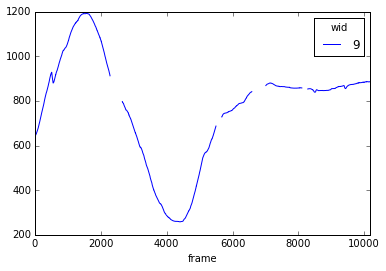

In [26]:
w_xdf[[9]].plot()

In [40]:
eid

'20160712_161305-1'

In [27]:
eid_df.loc['A9']
eid_df.loc['A245']

Blob_ids                                                                245
Start Time                                                           334921
End Time                                                             600070
Worms next ID                                                           288
Was Correct Throughout                                                   no
if, no, why?                                      part-multiworm, id-switch
Reason Lost                                                             NaN
# Correct Collisions      joins_w_untrackedworm.then-label-switches.toun...
# Wrong Collisions                                                      NaN
# Wrong Gaps                                                            NaN
name                                                                      A
minutes                                                             4.41915
good                                                                  False
collision   

In [28]:
# worm_tracks[9]
241 

[9, 245, 288]

In [49]:
wids = [i for i in w_xdf.columns if i != 241]
wids

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 77,
 15,
 16,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 68,
 26,
 28,
 44,
 45,
 46,
 247]

In [38]:
w_xdf[wids].to_csv(str(HUMAN_DIR / 'human_xdf_a.csv'))
w_ydf[wids].to_csv(str(HUMAN_DIR / 'human_ydf_a.csv'))

In [39]:
# xdif = xdf.diff()
# ydif = ydf.diff()

In [ ]:
# bdf = pd.DataFrame.from_csv(str(bfile_path), sep='\s', header=1, columns=np.arange(37)) #pd.read_csv(str(bfile_path), delimiter='\t')
# bdf.shape

#blob_dir, blob_dir.is_dir()
# for wdir in WALDO_DIR.glob('*'):
#     if not wdir.is_dir():
#         continue
        
#     eid = wdir.name
#     colision_rep = wdir / 'waldo' / (eid + '-collisions.csv')
#     cdf = pd.read_csv(str(colision_rep), index_col=0)
#     cdf = cdf[cdf['resolved']]
#     c = {'name': eid_to_name[eid],
#          'eid':eid,
#          '#collisions': len(cdf),
#     }
#     cdata.append(c)
# cdf = pd.DataFrame(cdata).set_index('name')
# cdf['#worms'] = sdf['#worms']
# csums = cdf.sum(axis=0)
# csums